## Machine Learning & Deep Learning

Wir geben dem Computer einen Lern-Algorithmus mit dem er die Vorhersage von bestimmten Variablen y auf Grundlage von einem möglichst großen Datensatz X lernt. 
<img src="img/ml_overview.png" alt="ml_overview" style="width: 500px;"/>

### Supervised vs. Unsupervised Learning

Beim Supervised Learning kennen wir die richtigen Antworten. Das Modell sagt y basierend auf X voraus.
Das Supervised Learning hat zwei Untertypen: **Classification** und **Regression**. Bei der Classification wird eine Kategorie, bei der Regression einen scalar vorhersagen.

Beim Unsupervised Learning geben wir die Daten X in ein Modell und untersuchen die Struktur der Daten, ohne zu wissen, wie das Ergebnis aussehen sollte.

Es gibt zahlreiche Machine Learning Modelle mit unterschiedlichen Vor- und Nachteilen. Welches Modell wir wählen hängt von der Fragestellung und den Eigenschaften (z.B. Größe von N, Anzahl an features, Format der Daten) ab. Oft probiert man mehrere Modelle aus, variiert die **Hyperparameter** und vergleicht deren **Metrics** (z.B. Anteil an richtigen Vorhersagen in %). Heute werden wir drei Modelle ausprobieren und sie in ihrer Vorhersagekraft vergleichen.

<img src="img/super_vs_unsuper.png" alt="learning" style="width: 500px;"/>

**1. Aufgabe**
Wir wollen das Inanspruchnahmeverhalten von psychologischer/ psychotherapeutischer Behandlung ("Have you ever sought treatment for a mental health issue from a mental health professional?", Yes/No) mithilfe von den Variablen zur Einstellung ggü. Mental Health im (Arbeits-)Umfeld vorhersagen, die wir in der letzten Sitzung vorverarbeitet haben. 
1. Handelt es sich dabei um Supervised oder Unsupervised Learning?
2. Handelt es sich dabei um Classification oder Regression?

Schreiben Sie mir die Antwort per Slack!

## Schritt 1: Importiere relevante Packages

Scikit-learn ist das bekanntest Python Package für Machine Learning. Es enthält die wichtigsten Modelle und Model Evaluation Metrics

In [1]:
import pandas as pd 
import numpy as np
import helpers

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, mean_squared_error, precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score


# Display plots inside the notebook
%matplotlib inline
sns.set(style="white", palette="pastel")

# Ignore warning related to pandas_profiling
import warnings
warnings.filterwarnings('ignore') 

from pathlib import Path

# Display all dataframe columns in outputs (it has 63 columns, which is wider than the notebook)
# This sets it up to display with a horizontal scroll instead of hiding the middle columns
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_colwidth', -1)

## Schritt 2: Train und Test Datensatz festlegen

In [2]:
# mit der Pickle Funktion packen wir den fertig bearbeiteten Dataframe in eine Datei, die wir nächste Woche einfach 
# importieren können. 
X = pd.read_pickle("X_df.pkl")
y = pd.read_pickle("y_df.pkl")

In [3]:
seed = 5 # wenn wir den seed festlegen können wir den random-split später reproduzieren
test_size = 0.33 # d.h. 33% des Datensatzes werden zufällig ausgewählt und dem Test- Datensatz zugeordnet.

# Durch den Train Test Split teilen wir den Datensatz in einen Train-Datensatz und einen Test-Datensatz auf. 
# Das Modell wird auf dem Train-Datensatz trainiert und am Test-Datensatz getestet.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

#### Vorbereitung zur Evaluierung von Modellen:
1. An den gleichen Daten trainieren und testen: Wir wissen nicht, ob das Modell auch für andere Daten gute Vorhersagen trifft. 
2. **Train/Test Split**: Teilt den Datensatz in zwei Teile auf, sodass an unterschiedlichen Daten gelernt und getestet wird. Bessere Schätzung der Out-of-Sample-Performance (=Generalisierung) als 1.

### 2.1 K-fold Cross-Validation

Bei der K-fold Cross-Validation wir der Datensatz in K verschiedene Subsamples (=folds) unterteilt. Jeder fold wird dabei einmal als Test-Datensatz benutzt (während die restlichen **K-1** folds zum Training genutzt werden). So kann die Modell-Güte an verschiedenen Datensätzen getestet werden und ist somit objektiver. Das Ergebnis sind **K** Accuracy-Scores, aus denen i.d.R. der Mittelwert gebildet wird. 

## Schritt 3: Modelle 

**Kurze Wiederholung Model Metrics:**
- **Accuracy** = Verhältnis der korrekten Vorhersagen zur Gesamtzahl der Vorhersagen. Wie oft ist der Classifier korrekt?

In [4]:
# Bevor wir die anderen Modelle anwenden legen wir ein Baseline Modelle fest. 
# Dieses überprüft, wie gut die Vorhersagekraft ist, wenn immer der Mittelwert vorhergesagt wird. 
# Die Vorhersagekraft unserer Modelle sollten nicht schlechter sein als das Baseline Modell.

# Create dummy classifer
dummy = DummyClassifier(strategy='uniform', random_state=seed)

# "Train" model
dummy.fit(X_train, y_train)
# Get accuracy score
dummy_accuracy = dummy.score(X_test, y_test) 
print(dummy_accuracy)

0.4957446808510638


### 3.1. Logistische Regression

Wir beginnen mit der logistischen Regression - ein gutes Einsteigermodell. Die logistische Regression ist - trotz des Namens - keine eigentliche Regression, sondern ein Klassifikationsmodell. Sie wird hautpsächlich für binäre Vorhersagen (z.B. Krankheit liegt vor/ Krankheit liegt nicht vor) verwendet.

Die logistische Regression verwendet ein lineares Modell, wandelt es jedoch mit Hilfe einer Exponentialfunktion, der so genannten Sigmoidfunktion, in **Wahrscheinlichkeiten** um.
Die logistische Regression modelliert also die logarithmische Wahrscheinlichkeit (genannt: Logit), dass die vorhergesagte Variable den Wert 1 (oder: Yes/True/ Liegt vor...) annimmt.

Der **classification treshold** (=Schwellenwert) legt fest, ab welcher Wahrscheinlichkeit wir davon ausgehen, dass die vorhergesagte Variable den Wert 1 annimmt. Er liegt standardmäßig bei 0.5. Ist die geschätzte Wahrscheinlichkeit für Yi = 1 größer (oder gleich) 0.5, so wird die i. Beobachtung als 1 klassifiziert, sonst wird von 0 ausgegangen. Der Schwellenwert kann je nach Fragestellung angepasst werden. 

<img src="img/linear_vs_log.png" alt="linear_vs_log" style="width: 400px;"/>

**2. Aufgabe** 

a.) Ein junger Berliner möchte mithilfe einer logistischen Regression vorhersagen, ob bei seinen Tinder-Matches der/die EINE dabei ist, mit der/dem er für IMMER glücklich sein wird. Wenn das Modell Ja sagt möchte er nicht zögern und die auserwählte Person umgehend seinen Eltern vorstellen. 

b.) Ein junger Berliner möchte mithilfe einer logistischen Regression vorhersagen, welches seiner Tinder-Matches potentiell auf ein Date mit ihm gehen würde. Er möchte alles mitnehmen was geht und nichts verpassen.  

Sollte man bei dem Modell in a.) den Schwellenwert hoch- oder runtersetzen? Sollte man bei dem Modell in b.) den Schwellenwert hoch- oder runtersetzen? Schreiben Sie mir die Antwort auf Slack!

### 3.1.1 Modell anlegen,  trainieren und evaluieren

In [5]:
# Modell anlegen. Der Hyperparameter C legt die Regularization Strength fest, d.h. wie sehr falsche Vorhersagen 
# "bestraft" werden. Große Werte von C erlauben Fehler und damit komplexere Modelle - dafür ist das Risiko von
# "Overfitting" erhöht. Kleine Werte von C bestrafen Fehler stärker, d.h. das Modell wird einfacher.
# Wenn es zu einfach wird droht "Underfitting"

log_model = LogisticRegression(C=1.0) # Lege ein Modell an. C ist hier auf dem Default. 
log_model.fit(X_train, y_train) # trainiere das Modell, sodass es bessere Vorhersagen trifft

LogisticRegression()

In [6]:
# Zunächst sagen wir unseren Testdatensatz mithilfe des Train Datensatzes vorher. 

y_pred_train = log_model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred_train)
print("Train Accuracy: {}".format(accuracy))


# Nun sagen wir unseren Testdatensatz mithilfe des Test Datensatzes vorher. 
# Dieser wurde von unserem Modell noch nie gesehen. 

y_pred_test = log_model.predict(X_test)
    
log_accuracy = accuracy_score(y_test, y_pred_test)
print("\nTest Accuracy: {}".format(log_accuracy))

Train Accuracy: 0.8614900314795383

Test Accuracy: 0.825531914893617


**3. Aufgabe (Hyperparameter Tuning):**
- setzen Sie unterschiedliche Werte für den Hyperparameter C ein und schauen Sie, wie sich die Train Accuracy und die Test Accuracy verändern. Behalten Sie den besten Wert (Default ist C=1.0. Die Werte für C müssen > 0 sein).
- Was beobachten Sie für unterschiedliche Werte von C? Was bedeutet es, wenn die Train Accuracy höher ist, als die Test Accuracy? Schreiben Sie mir auf Slack. 

### 3.1.2 Vorhersagen visualisieren

In [7]:
# Erstelle einen Dataframe mit True und Predicted Values und der errechneten Wahrscheinlichkeit  

probabilities = log_model.predict_proba(X_test)

log_df = pd.DataFrame(zip(y_test, y_pred_test, probabilities), 
                   columns = ["Actual Value", "Predicted Value", "Probability (left: No, right: Yes)"])

log_df["Result"] = np.where(log_df["Actual Value"] == log_df["Predicted Value"], "Right", "Wrong")


log_df.set_index("Actual Value").head(10)

,Predicted Value,"Probability (left: No, right: Yes)",Result
Actual Value,,,
1,1,"[0.1963175677623954, 0.8036824322376046]",Right
1,1,"[0.06875050341843991, 0.9312494965815601]",Right
0,0,"[0.804661381846588, 0.195338618153412]",Right
1,0,"[0.7991610321635414, 0.20083896783645866]",Wrong
1,1,"[0.1967907173382175, 0.8032092826617825]",Right
1,1,"[0.1945473571767854, 0.8054526428232146]",Right
1,1,"[0.07219009701265067, 0.9278099029873493]",Right
0,0,"[0.9278437959044844, 0.07215620409551557]",Right
0,1,"[0.35979035185356, 0.64020964814644]",Wrong


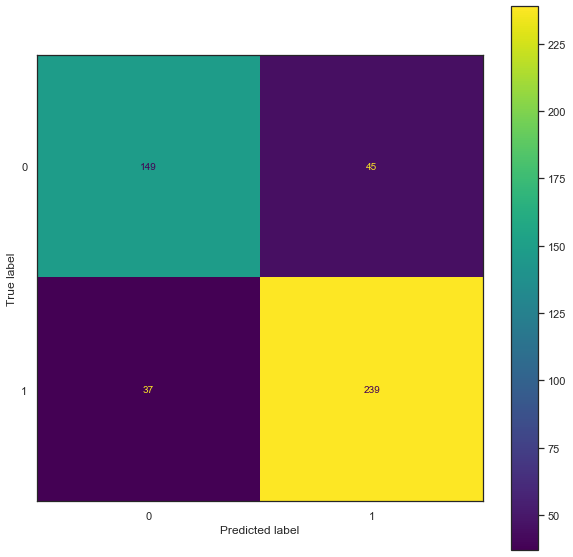

In [8]:
# Plot Confusion Matrix 
fig, ax = plt.subplots(figsize=(10, 10))

confusion_matrix(y_pred_test, y_test)
metrics.plot_confusion_matrix(log_model, X_test, y_test, normalize=None, ax=ax)

**Vorteile der logistischen Regression:**
- schnelle Rechenzeit
- Input Vektor X kann skalar, ordinal, kategorial oder eine Mischung davon sein
- der classification treshold kann angepasst werden, um entweder Sensitivität (Recall) oder Spezifität (Precision)  zu optimieren
- liefert Wahrscheinlichkeiten

**Nachteile der logistischen Regression:**
- erfordert manuelles Feature-Engineering (z.B. One-Hot-Encoding)
- Class Imbalance kann die Koeffizienten stark beeinflussen
- Der Classification Treshold ist immer linear

### 3. 2. Support Vector Classifier (SVC)

Support Vector Machines haben Sie in der Sitzung vor 3 Wochen bereits kennengelernt (die Mood Rythm App). Eine Support Vector Machine versucht die beste **decision boundary (oder Hyperplane bei >2 Features)** für die Klassifizierung von Datenpunkten zu geben. Die beste decision boundary ist dabei eine, die eine möglichst große **margin** hat und gleichzeitig möglichst wenige falsche Klassifizierungen. 
 
<img src="img/cats_SVM.png" alt="svm_cats" style="width: 400px;"/>

Wenn die Daten nicht (wie in den oberen Beispielen) linear trennbar sind können wir den **Kernel Trick** anwenden. In diesem Fall projizieren wir die Daten von einem 2D in einen 3(oder mehr)D Raum und schauen, ob sich so eine optimale Hyperplane finden lässt. Der Kernel ist dabei die mathematische Funktion, die wir anwenden, um die Daten optimal zu transformieren. 
Es gibt viele verschiedene Kernels, was Support Vector Machines extrem flexibel macht.
Wir werden uns heute den **RBF Kernel** ansehen und ihn mit der Linearen Support Vector Machine vergleichen. 

<img src="img/kernel_trick_1.png" alt="svm_kernel1" style="width: 400px;"/>
<img src="img/kernel_trick_2.png" alt="svm_kernel2" style="width: 600px;"/>

Das Strafmaß (= penalty) für falsche Klassifizierungen wird wieder durch den Hyperparameter **C** kontrolliert. Je weiter ein falsch klassifizierter Datenpunkt von der decision boundary entfernt ist, desto größer die Strafe. 
C verhält sich hier anders als bei der Logistischen Regression: Bei einem kleinen C ist der Classifier recht entspannt, was falsche Vorhersagen angeht (Konsequenz: High Bias, Low Variance --> Underfitting). Je größer C desto stärker wird das Modell für falsche Vorhersagen bestraft (Konsequenz: High Variance, Low Bias --> Overfitting).

<img src="img/C_regularization.png" alt="C" style="width: 600px;"/>

Bei Linearen SVM müssen wir nur C festlegen. Bei nicht linearen Kernels, z.B. auch dem RBF Kernel müssen wir außerdem den Hyperparameter **gamma** optimieren. Dieser legt fest, welche Punkte in das Training miteinbezogen werden. Wenn Gamma niedrig ist, ist die "Kurvigkeit" der Entscheidungsgrenze sehr flach und damit die Entscheidungsregion sehr breit (--> Underfitting). Wenn das Gamma hoch ist, ist die "Kurvigkeit" der Entscheidungsgrenze hoch, wodurch Inseln von Entscheidungsgrenzen um Datenpunkte herum entstehen (--> Overfitting). Hier zwei Beispiele für gamma = 1.0 und gamma= 100


<img src="img/gamma_1.0.png" alt="C" style="width: 400px;"/>
<img src="img/gamma_100.png" alt="C" style="width: 400px;"/>

### 3.2.1 Modell anlegen,  trainieren und evaluieren

#### 3.2.1.1 Linear SVM

In [9]:
# Legen Sie einen Linear Support Vector Classifier an
linear_svc = LinearSVC(C=0.001)

In [10]:
# Trainiere das Modell mit unserem Train Datensatz
linear_svc = linear_svc.fit(X_train, y_train)

In [11]:
# Zuerst sagen wir unsere Zielvariable mithilfe des Test Datensatzes vorher. 

y_pred_train = linear_svc.predict(X_train)

lin_svc_accuracy = accuracy_score(y_train, y_pred_train)
print("Train Accuracy: {}".format(lin_svc_accuracy))

# Nun sagen wir unsere Zielvariable mithilfe des Test Datensatzes vorher. 

y_pred_test = linear_svc.predict(X_test)
    
svm_lin_accuracy = accuracy_score(y_test, y_pred_test)
print("\nTest Accuracy: {}".format(svm_lin_accuracy))

Train Accuracy: 0.8415529905561385

Test Accuracy: 0.8404255319148937


#### 3.2.1.2 SVM mit RBF Kernel 

In [12]:
# Legen Sie einen Support Vector Classifier mit RBF Kernel an
rbf_svc = SVC(kernel='rbf', random_state=0, gamma=0.03, C=1.0, probability=True)

# Trainieren Sie den Classifier
rbf_svc.fit(X_train, y_train)

SVC(gamma=0.03, probability=True, random_state=0)

In [13]:
# Zuerst sagen wir unsere Zielvariable mithilfe des Test Datensatzes vorher. 

y_pred_train = rbf_svc.predict(X_train)

accuracy = accuracy_score(y_train, y_pred_train)
print("Train Accuracy: {}".format(accuracy))

# Nun sagen wir unsere Zielvariable mithilfe des Test Datensatzes vorher. 

y_pred_test = rbf_svc.predict(X_test)
    
rbf_svc_accuracy = accuracy_score(y_test, y_pred_test)
print("\nTest Accuracy: {}".format(rbf_svc_accuracy))

Train Accuracy: 0.844700944386149

Test Accuracy: 0.8468085106382979


**4. Aufgabe (Hyperparameter Tuning II):**
- setzen Sie unterschiedliche Werte für die Hyperparameter C und gamma ein und schauen Sie, wie sich die Train Accuracy und die Test Accuracy verändern.(Die Werte für C und gamma müssen > 0 sein). Was beobachten Sie für verschiedene Werte von C und gamma? Schreiben Sie mir auf Slack! 
- Notieren Sie sich ihre getesteten Werte und die ensprechende Accuracy. Behalten Sie das beste Modell.

### 3.2.2 Vorhersagen visualisieren

In [14]:
probabilities = rbf_svc.predict_proba(X_test)
svm_df = pd.DataFrame(zip(y_test, y_pred_test, probabilities), 
                   columns = ["Actual Value", "Predicted Value", "Probability (left: No, right: Yes)"])

svm_df["Result"] = np.where(log_df["Actual Value"] == log_df["Predicted Value"], "Right", "Wrong")

svm_df.set_index("Actual Value").head(10)

,Predicted Value,"Probability (left: No, right: Yes)",Result
Actual Value,,,
1,1,"[0.14079178047353716, 0.8592082195264631]",Right
1,1,"[0.1404863751485743, 0.8595136248514257]",Right
0,0,"[0.8740129650831265, 0.12598703491687352]",Right
1,0,"[0.8776825978036142, 0.12231740219638598]",Wrong
1,1,"[0.18833957961381723, 0.8116604203861828]",Right
1,1,"[0.16472698376547085, 0.835273016234529]",Right
1,1,"[0.18879581890119934, 0.8112041810988004]",Right
0,0,"[0.9150677712838436, 0.08493222871615634]",Right
0,0,"[0.5622520337470261, 0.43774796625297396]",Wrong


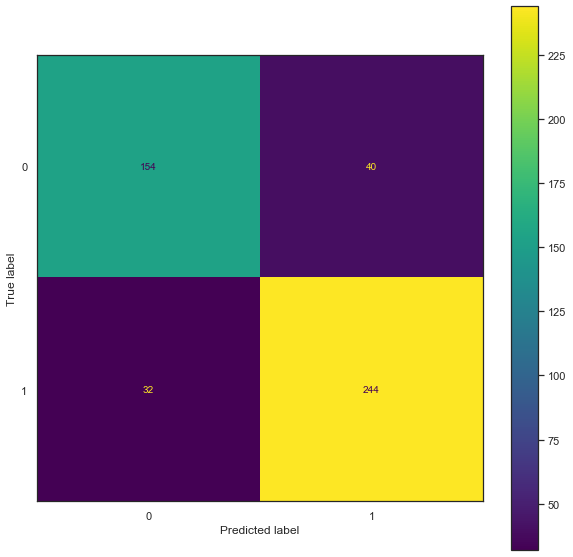

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

confusion_matrix(y_pred_test, y_test)
metrics.plot_confusion_matrix(rbf_svc, X_test, y_test, normalize=None, ax=ax)

**Vorteile von Support Vector Machines:**
- erfordern weniger Feature-Engineering als z.B. die logistische Regression
- kann nichtlineare Entscheidungsgrenzen erzeugen
- kann mit vielen Features umgehen
- ein LogReg kann auf einer SVM ausgeführt werden, um Wahrscheinlichkeiten zu erzeugen

**Nachteile von Support Vector Machines:**
- erfordert skalierte Daten
- erzeugt nicht von sich aus Wahrscheinlichkeiten
- wird bei großen Datensätzen langsam

### 3.3 Deep Learning

Neuronale Netzwerke und Deep Learning haben Sie ebenfalls in der letzten Machine Learning Sitzung behandelt ("Depressionen am EEG erkennen"). Wir werden heute ein etwas simpleres Neuronales Netzwerk bauen, ein sogenanntes **Feed-Forward Neural Network**. Das Feed-Forward Neural Network besteht aus einer/mehreren Hidden Layer(s), durch die Informationen von links nach rechts geschickt werden: 

<img src="img/neuron.png" alt="neuron" style="width: 400px;"/>



Weitere Informationen:
https://youtu.be/aircAruvnKk

In [16]:
# Erstmal Tensorflow runterladen über Anaconda Navigator --> Open Terminal --> conda install tensorflow

import tensorflow as tf
#from tensorflow import keras
from sklearn import preprocessing

from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Flatten


In [17]:
# Wir müssen die Datensätze zu einem numpy array transformieren, um sie in das Modell einlesen zu können.
train_x = np.asarray(X_train)
train_y = np.asarray(y_train)
validation_x = np.asarray(X_test)
validation_y = np.asarray(y_test)

#### 3.3.1 Construct Neural Network Architecture

In [18]:
X_train.shape[1]
feature_nr = X_train.shape[1] 

deep_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(feature_nr,)), # die Input shape hängt von der Anzahl an features ab
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid), 
])

#### 3.3.2 Compile Feedforward Neural Network

In [19]:
# Compiling = Konvertieren sie das Modell in eine Form, die vom Computer ausgeführt werden kann
deep_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### 3.3.3  Feedforward Neural Network trainieren und evaluieren

Relevante Hyperparameter:
- Batch_size = Größe d. Subsets der Daten, mit dem das Modell trainiert (Viel effizienter als den ganzen Datensatz einzulesen
- Epochs = Anzahl an Runden, die das Modell trainiert. Eine Epoch ist vorbei, wenn das Modell jeden Batch und damit jeden Datenpunkt einmal gesehen hat 

In [20]:
history = deep_model.fit(train_x, train_y, 
                         epochs=10, 
                         verbose = 1, 
                         batch_size=50, 
                         validation_data=(validation_x, validation_y))

test_loss, test_acc = deep_model.evaluate(validation_x, validation_y)
print('Test accuracy:', test_acc)

deep_accuracy = test_acc

Train on 953 samples, validate on 470 samples
Epoch 1/10
953/953 [==============================] - 1s 1ms/sample - loss: 0.6503 - accuracy: 0.6453 - val_loss: 0.6365 - val_accuracy: 0.6660
Epoch 2/10
953/953 [==============================] - 0s 91us/sample - loss: 0.6160 - accuracy: 0.6863 - val_loss: 0.6004 - val_accuracy: 0.7404
Epoch 3/10
953/953 [==============================] - 0s 91us/sample - loss: 0.5708 - accuracy: 0.7639 - val_loss: 0.5563 - val_accuracy: 0.7745
Epoch 4/10
953/953 [==============================] - 0s 90us/sample - loss: 0.5229 - accuracy: 0.7922 - val_loss: 0.5095 - val_accuracy: 0.7830
Epoch 5/10
953/953 [==============================] - 0s 91us/sample - loss: 0.4939 - accuracy: 0.7870 - val_loss: 0.4781 - val_accuracy: 0.7915
Epoch 6/10
953/953 [==============================] - 0s 90us/sample - loss: 0.4545 - accuracy: 0.8132 - val_loss: 0.4575 - val_accuracy: 0.8085
Epoch 7/10
953/953 [==============================] - 0s 90us/sample - loss: 0.4308 -

Test accuracy: 0.81914896


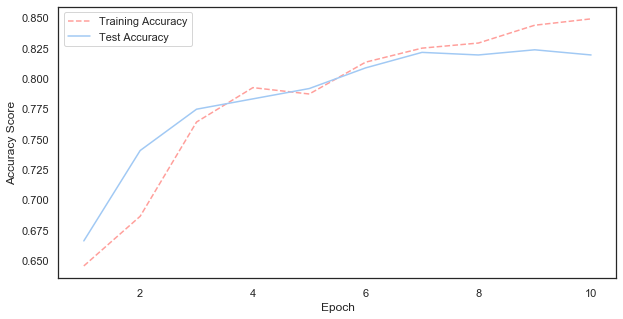

In [21]:
# Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize accuracy history
plt.figure(figsize=(10,5))
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.show();

### Compare all models 

In [22]:
methodDict = {}
methodDict['Dummy'] = dummy_accuracy
methodDict['Linear_SVC'] = svm_lin_accuracy
methodDict['RBF_Kernel'] = rbf_svc_accuracy
methodDict['Neural_Network'] = deep_accuracy

In [23]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(6,6))
    #Colors
    ax = s.plot(kind='bar') 
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    #plt.ylim([30.0, 90.0])
    plt.xlabel('Method')
    plt.ylabel('Percentage')
    plt.title('Success of methods')
     
    plt.show()

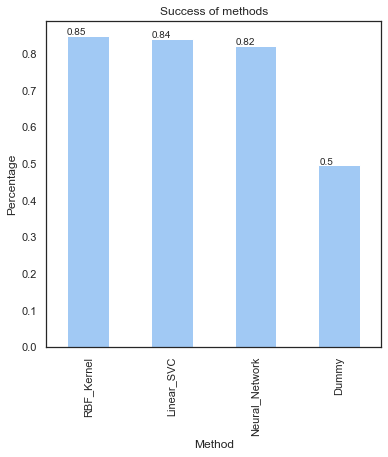

In [24]:
#sns.set()

plotSuccess()

### Weitere Ressourcen:

- Chris Albon ist Autor von dem gern genutzten "Machine Learning with Python Cookbook". Auf seiner Seite finden sich ziemlich viele und gute Ressourcen https://chrisalbon.com/